# Lab - Distributions

1. Get the numerical variables from our dataset.
2. Check using a distribution plot if the variables fit the theoretical normal or exponential distribution.
3. Check if any of the transformations (log-transform, etc.) we have seen up to this point changes the result.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df = pd.read_csv('files_for_lab/we_fn_use_c_marketing_customer_value_analysis.csv')

In [3]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.head(2)

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize


In [4]:
numericals = df.select_dtypes('number')

##  Distributions - Transformations 

Text(0.5, 1.0, 'Exponential Distribution')

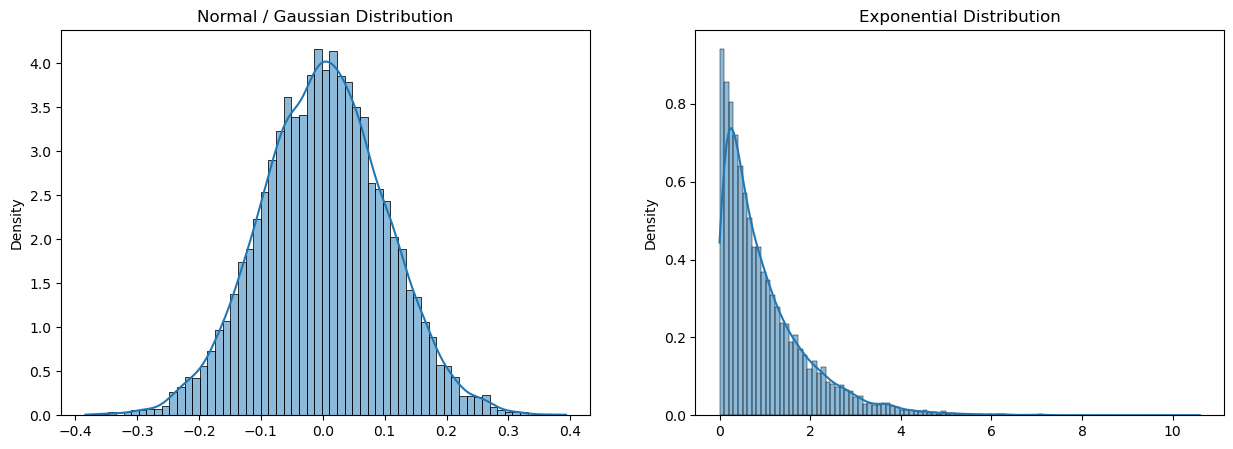

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


# normal / Gaussian distribution shape
rng = np.random.default_rng()
mu, sigma = 0, 0.1 # mean and standard deviation
x_nor = rng.normal(mu, sigma, 10_000)
# exponential distribution
x_exp = rng.exponential(1, 10_000)

sns.histplot(data=x_nor, kde=True, stat='density', ax=ax[0])
sns.histplot(data=x_exp, kde=True, stat='density', ax=ax[1])
ax[0].set_title('Normal / Gaussian Distribution')
ax[1].set_title('Exponential Distribution')

In [6]:
SAFETY_MARGIN = 0.1
TARGET = 'total_claim_amount'
comparisson = pd.DataFrame([], columns=['feature', 'corr_to_target_initial', 
                                        'corr_to_target_post_transform', 'method', 'diff_abs'])

# helper func for distribution plots
def plot_distribution(df, col):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.histplot(data=df[col], kde=True, stat='density', ax=ax[0])
    ax[0].lines[0].set_color('blue')
    ax[0].set_title(f'Histogram + KDE curve for {col}')
  
    plt.subplot(1, 2, 2)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.show()


def display_corr_to_target(df, col, col_new, method):
    corr_initial = df[TARGET].corr(df[col])
    corr_new = df[TARGET].corr(df[col_new])
    corr_diff = abs(corr_initial) - abs(corr_new)
    
    # add vals to comparisson overview
    comparisson.loc[comparisson.shape[0]+1] = [col, corr_initial, corr_new, method, corr_diff]
    
# helper func for log tranformation
def log_transform(df, col):
    df[f'{col}_log'] = np.log(df[col]+SAFETY_MARGIN)
    display_corr_to_target(df, col, f'{col}_log', 'log')
    plot_distribution(df, f'{col}_log')
    df.drop(f'{col}_log', axis=1, inplace=True)
    
# helper func for reciprocal tranformation    
def rec_transform(df, col):
    df[f'{col}_rec'] = 1/(df[col]+SAFETY_MARGIN)
    plot_distribution(df, f'{col}_rec')
    display_corr_to_target(df, col, f'{col}_rec', 'rec')
    df.drop(f'{col}_rec', axis=1, inplace=True)
    

# helper func for square root tranformation    
def sq_transform(df, col):
    df[f'{col}_sq'] = df[col]**(1/2)
    display_corr_to_target(df, col, f'{col}_sq', 'sq')
    plot_distribution(df, f'{col}_sq')
    df.drop(f'{col}_sq', axis=1, inplace=True)
    

# helper func for exponential tranformation    
def exp_transform(df, col):
    df[f'{col}_exp'] = df[col]**(1/5)
    display_corr_to_target(df, col, f'{col}_exp', 'exp')
    plot_distribution(df, f'{col}_exp')
    df.drop(f'{col}_exp', axis=1, inplace=True)
    
    
# helper func for boxcox tranformation    
def boxcox_transform(df, col):
    df[f'{col}_boxcox'], _ = stats.boxcox(df[col]+SAFETY_MARGIN)
    display_corr_to_target(df, col, f'{col}_boxcox', 'boxcox')
    plot_distribution(df, f'{col}_boxcox')
    df.drop(f'{col}_boxcox', axis=1, inplace=True)
    
    
def apply_all_transformations(df, col):
    plot_distribution(df, col)
    log_transform(df, col)
    rec_transform(df, col)
    sq_transform(df, col)
    exp_transform(df, col)
    boxcox_transform(df, col)

### Check the unique vals in numerical features

In [7]:
df['number_of_open_complaints'].unique()

array([0, 2, 1, 3, 5, 4])

In [8]:
df['number_of_policies'].unique()

array([1, 8, 2, 7, 9, 4, 3, 6, 5])

In [9]:
df['months_since_last_claim'].unique()

array([32, 13, 18, 12, 14,  0, 17, 23, 27,  9, 21, 11, 31,  8,  4, 30, 22,
       15, 33,  1, 19, 28, 10,  7,  3,  5, 20, 24, 29, 34,  6, 35,  2, 16,
       26, 25])

- I would not subject these three features to transformations - discrete features

### Check skew

In [10]:
numericals.skew().sort_values()

months_since_policy_inception    0.040165
months_since_last_claim          0.278586
income                           0.286887
number_of_policies               1.253333
total_claim_amount               1.714966
monthly_premium_auto             2.123546
number_of_open_complaints        2.783263
customer_lifetime_value          3.032280
dtype: float64

- apply transformation only to the features where skew is above a certain threshold (here: 0.28)
- exclude target
- exclude number_of_open_complaints
- exlude number_of_policies

In [11]:
relevant_nums = list(numericals.skew().sort_values().index)[2:]
relevant_nums.remove(TARGET)
relevant_nums.remove('number_of_open_complaints')
relevant_nums.remove('number_of_policies')
relevant_nums

['income', 'monthly_premium_auto', 'customer_lifetime_value']

In [12]:
numericals.kurt()

customer_lifetime_value          13.823533
income                           -1.094326
monthly_premium_auto              6.193605
months_since_last_claim          -1.073668
months_since_policy_inception    -1.133046
number_of_open_complaints         7.749308
number_of_policies                0.363157
total_claim_amount                5.979401
dtype: float64

### Apply transfromations

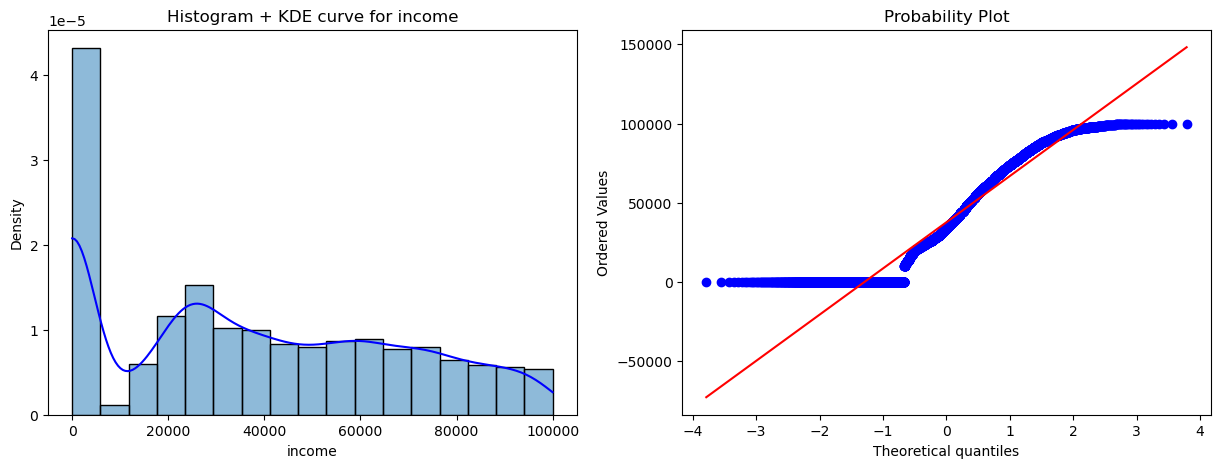

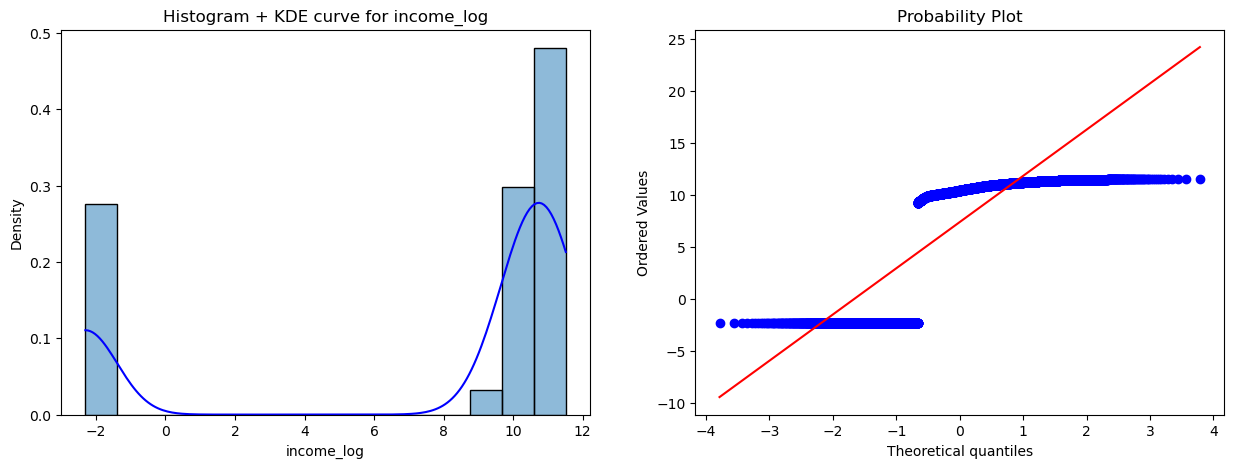

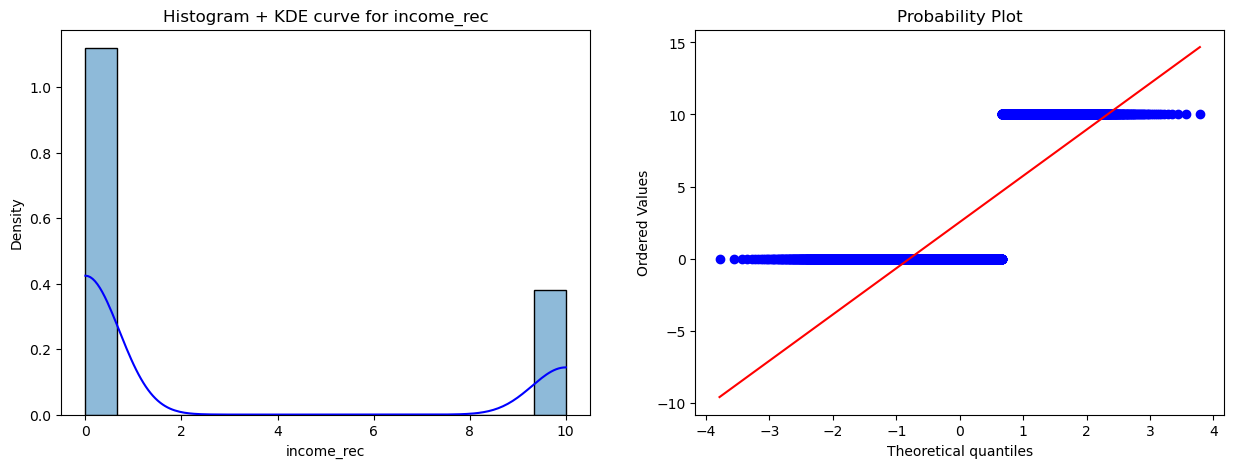

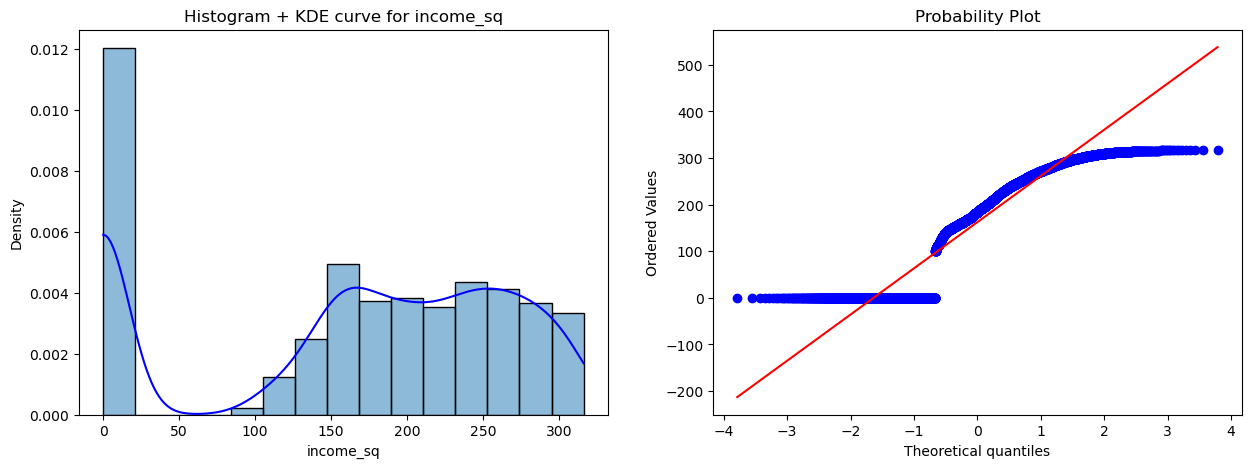

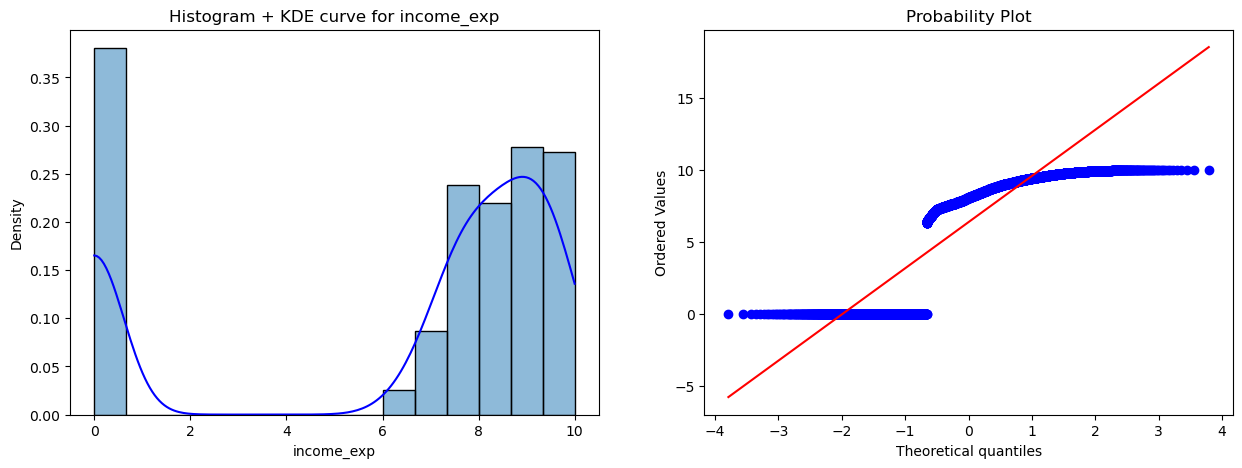

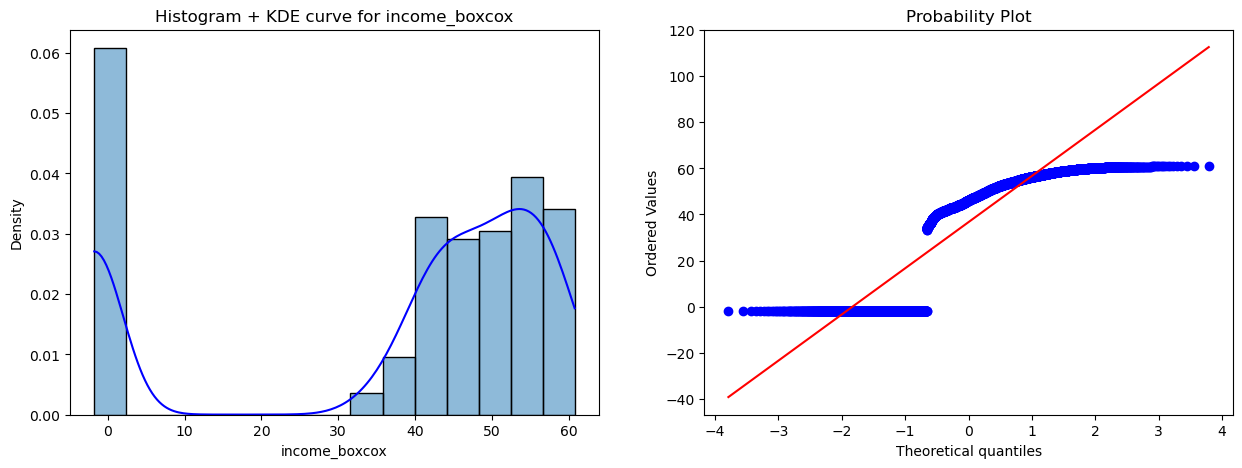

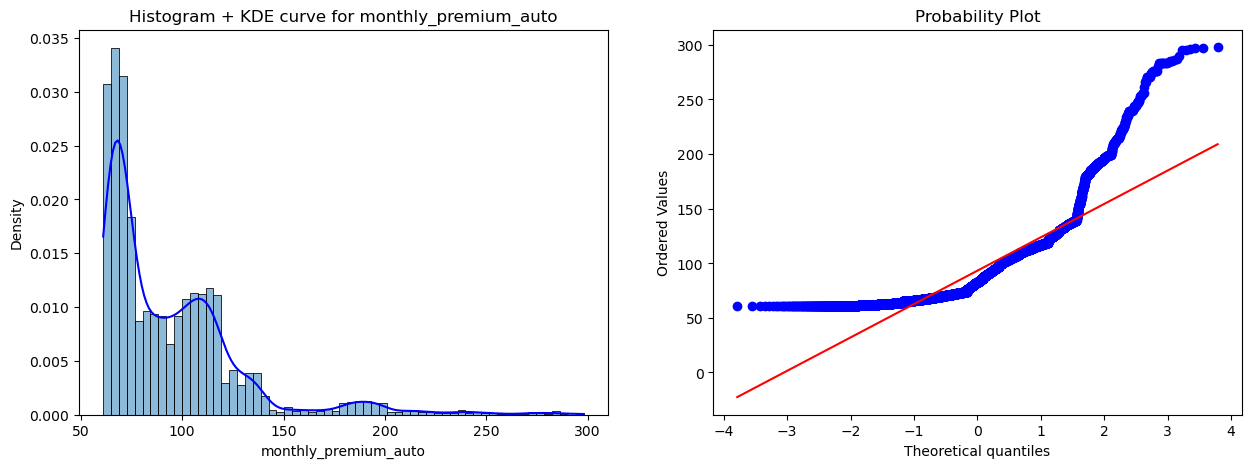

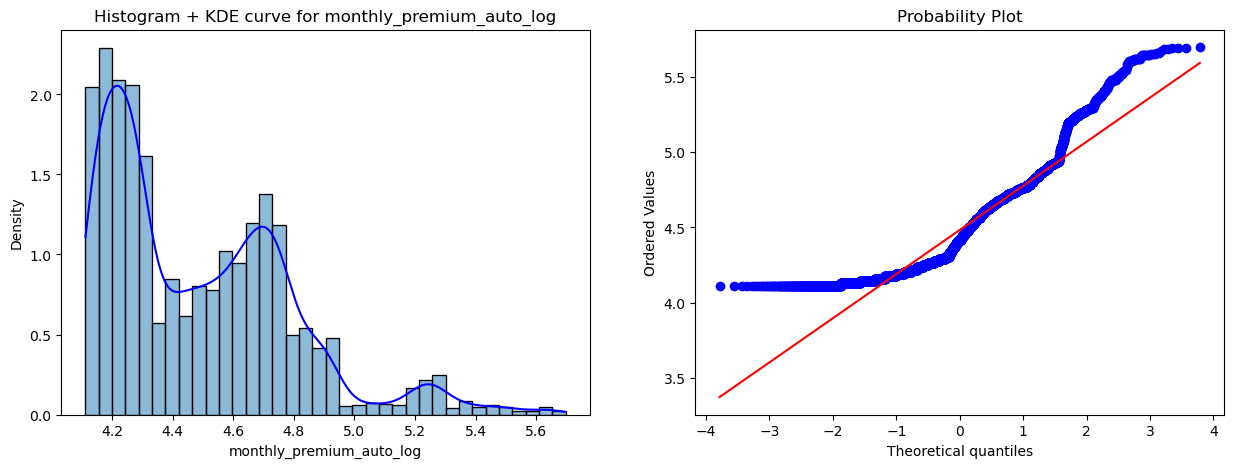

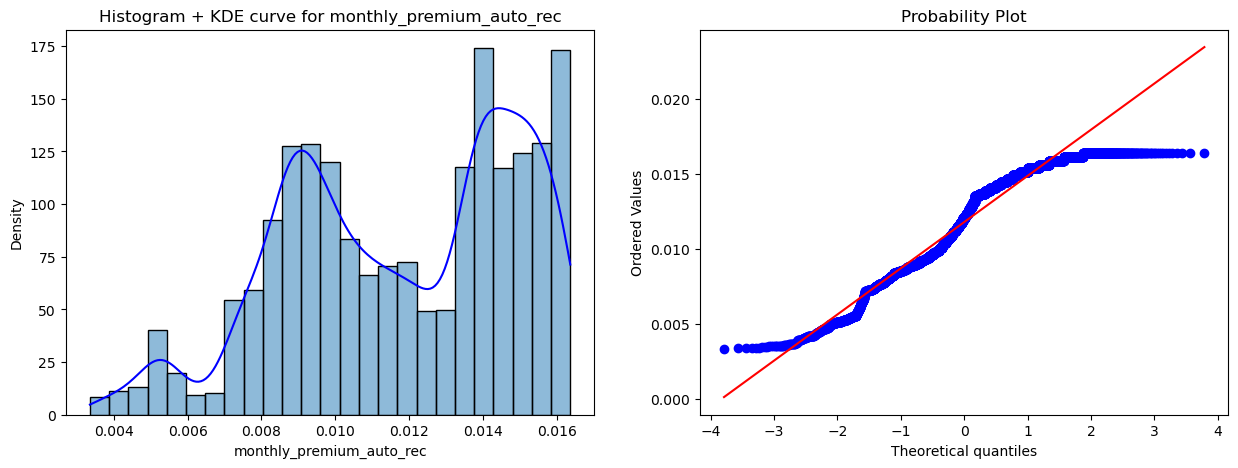

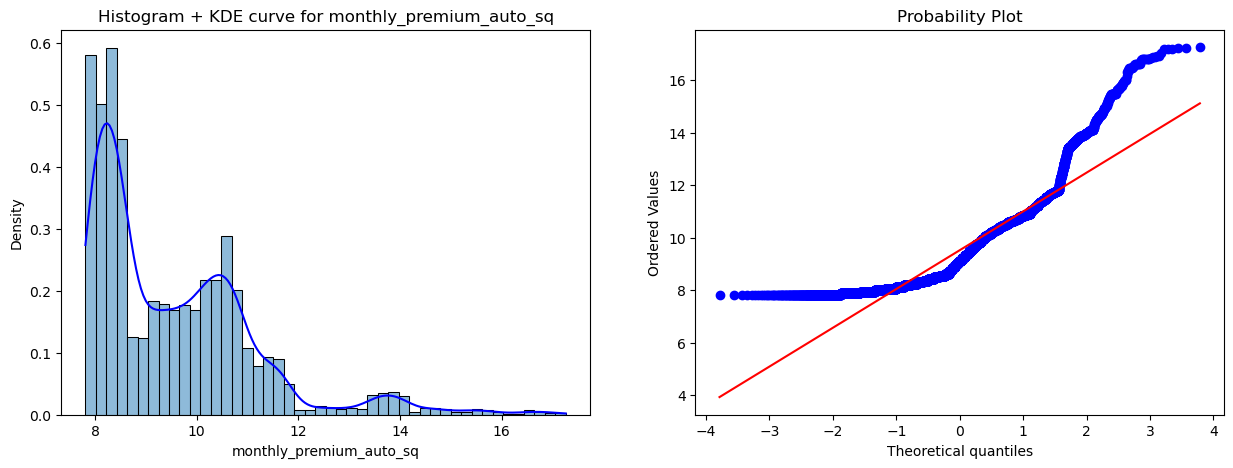

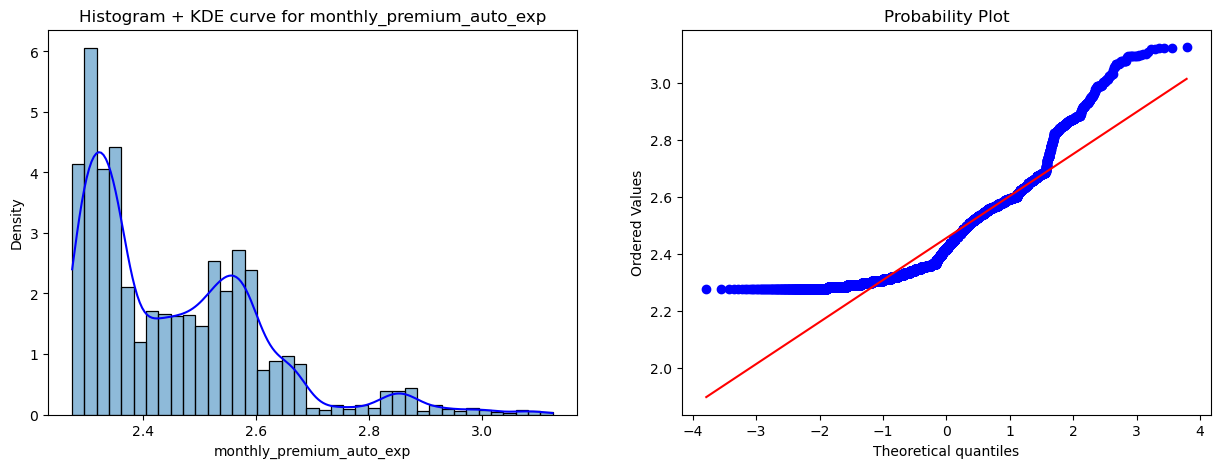

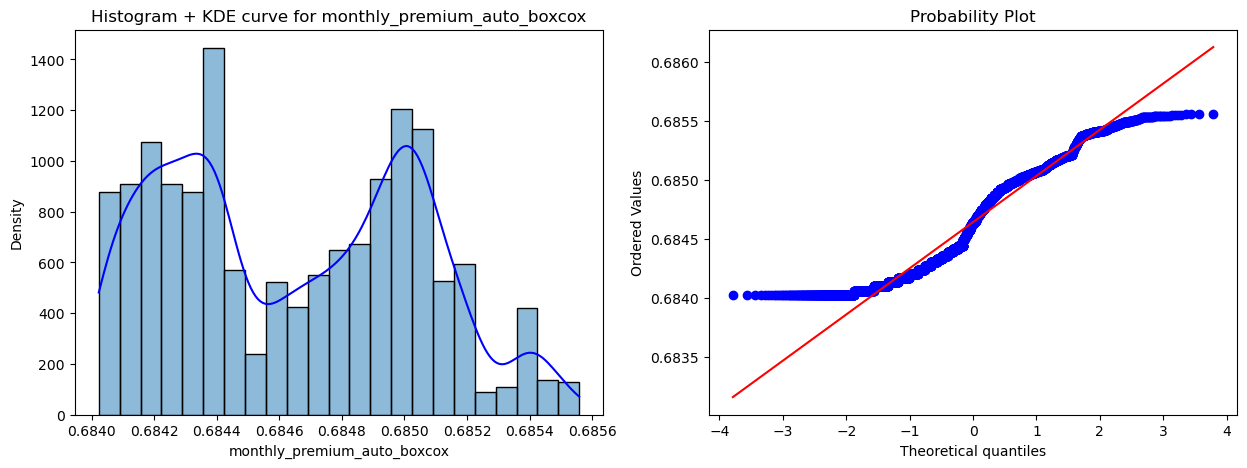

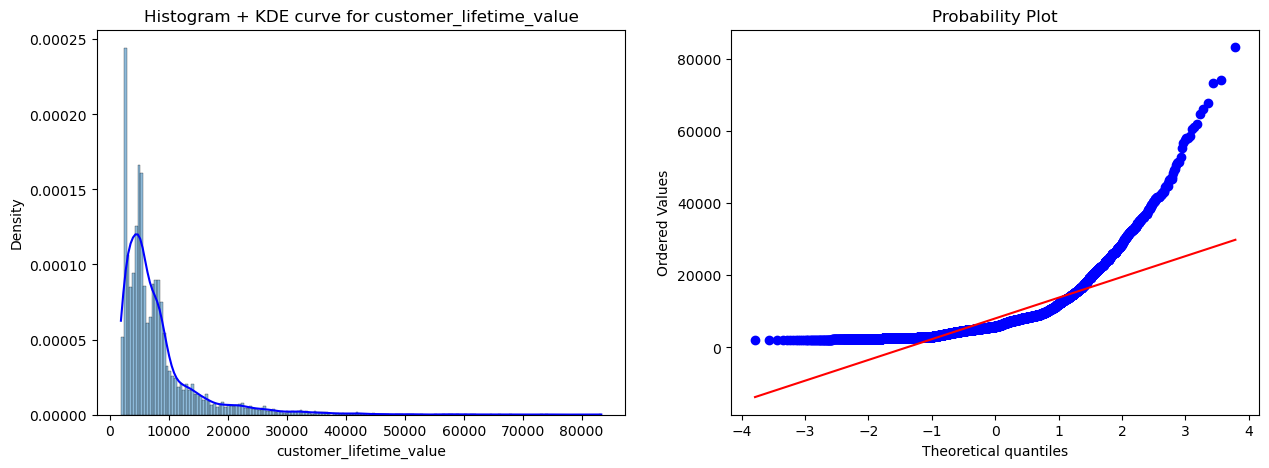

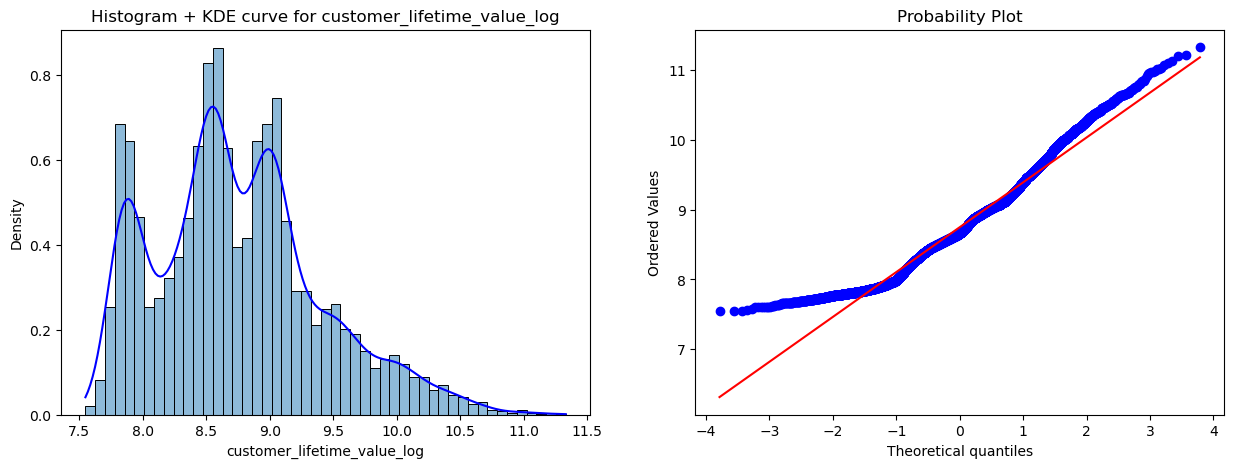

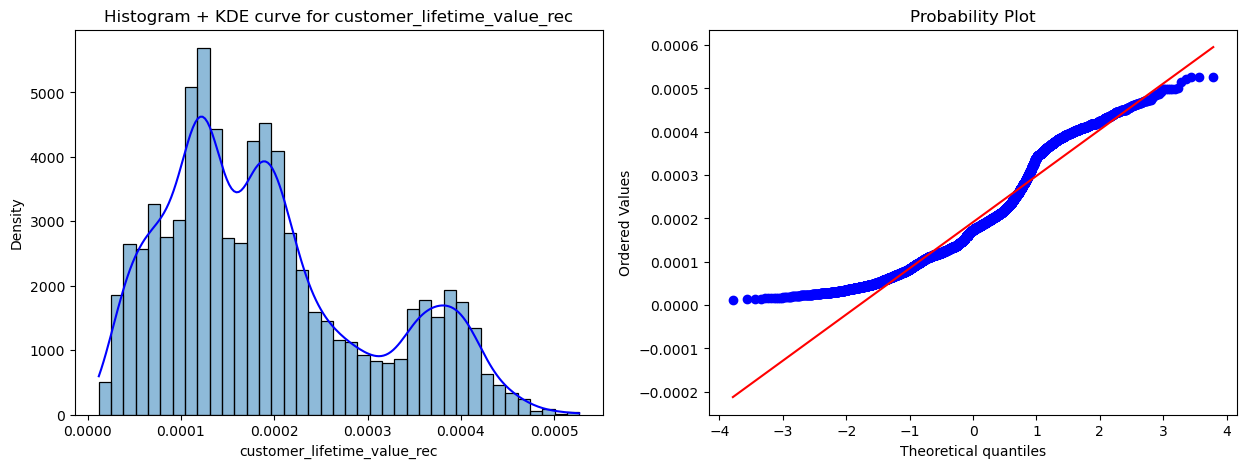

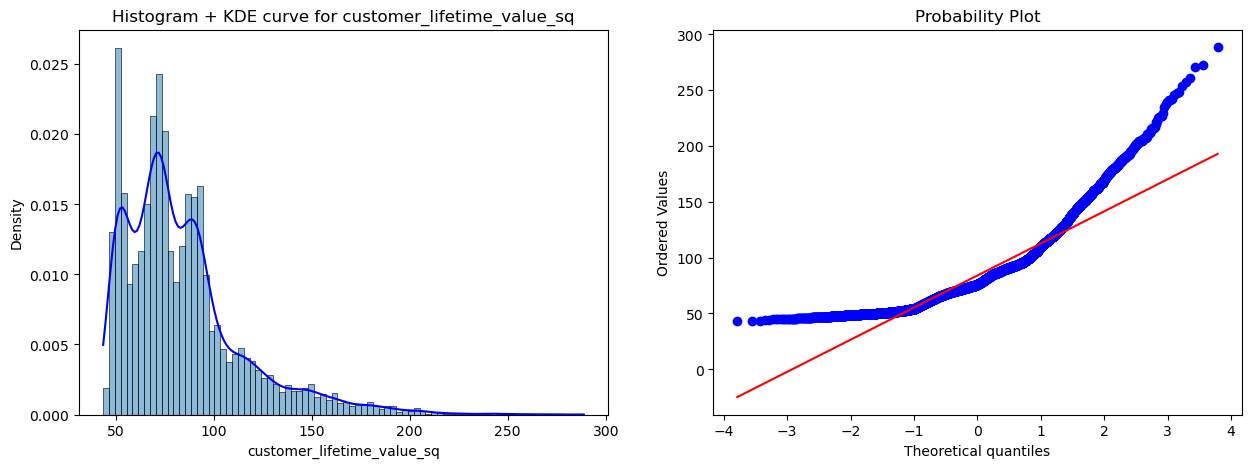

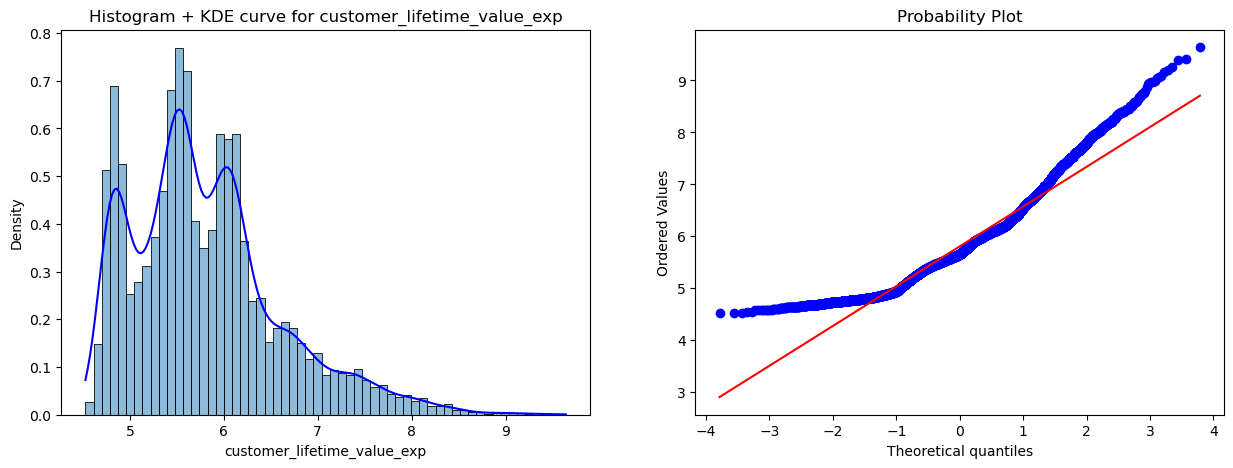

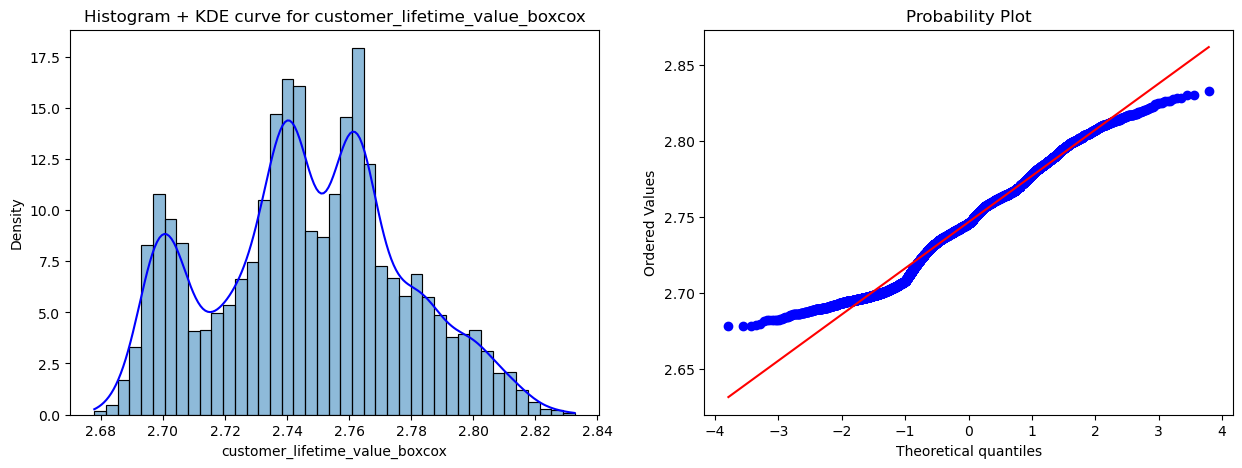

In [13]:
for col in relevant_nums:
    apply_all_transformations(df, col)
    print('='*110)

## Check how transformation affect correlation to target

In [14]:
comparisson.sort_values(by='diff_abs', ascending=False)

,feature,corr_to_target_initial,corr_to_target_post_transform,method,diff_abs
10,monthly_premium_auto,0.632017,0.545682,boxcox,0.086334
7,monthly_premium_auto,0.632017,-0.565442,rec,0.066575
6,monthly_premium_auto,0.632017,0.607253,log,0.024764
2,income,-0.355254,0.332138,rec,0.023116
9,monthly_premium_auto,0.632017,0.614265,exp,0.017752
1,income,-0.355254,-0.345225,log,0.010030
8,monthly_premium_auto,0.632017,0.623167,sq,0.008849
12,customer_lifetime_value,0.226451,-0.228801,rec,-0.002350
4,income,-0.355254,-0.360408,exp,-0.005154
5,income,-0.355254,-0.364726,boxcox,-0.009471


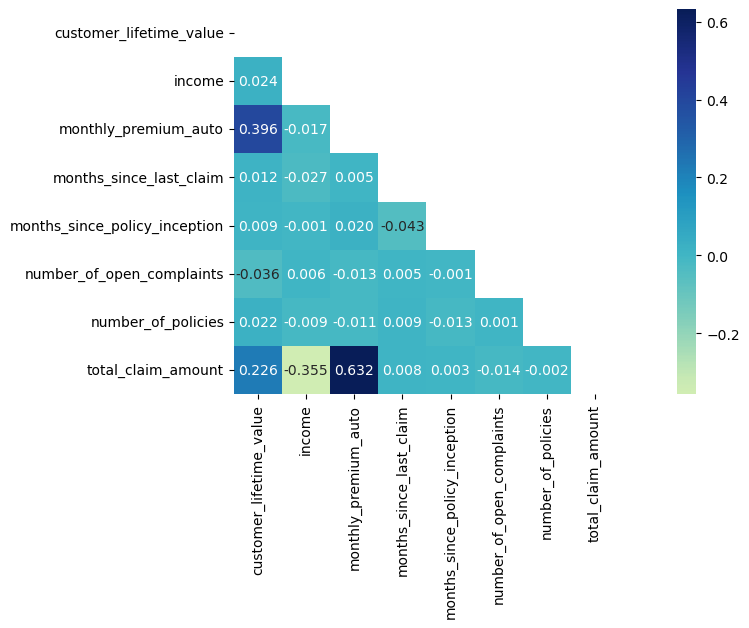

In [15]:
# correlation matrix for numerical cols
num_corr = df.select_dtypes('number').corr()
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.heatmap(num_corr, center=0, fmt=".3f", square=True, annot=True, mask=mask, cmap="YlGnBu")
plt.show()

##  Observations
- income feature: I would leave it as is - no transfromation
- monthly_premium_auto: some improvement with boxcox transformation
- customer_lifetime_value: big improvement with log and boxcox transform; would apply one of these